## Randomised benchmarking

Randomised benchmarking on multiple qubits consitsts of inserting a set of randomly chosen Clifford group gates into a circuit, and checking that the outcome is the expected outcome. Clifford group gates are chosen to be deterministic and classically simulable. We will restrict ourselves to CNOT and rotations about a major axis (Rx, Ry, Rz).

Here we will write some code to perform randomised benchmarking on the Rigetti Acorn chip.

For a paper on randomised benchmarking on superconducting qubits, see: https://arxiv.org/pdf/0707.0963.pdf

In [1]:
import numpy as np
import copy
from random import randint
import pyquil
from pyquil.quil import Program, Pragma
from pyquil.api import QVMConnection
from pyquil.api import QPUConnection
from pyquil.api import get_devices
from pyquil.gates import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import collections
%matplotlib inline

In [2]:
#Function to decide upon randomised gates, up to a limit
def randomGates(qubit_a = 0, no_of_gates = 30):
    prog = Program()
    sequence_length = no_of_gates
    sequence = [0]*sequence_length
    inverse_sequence = [0]*sequence_length
    
    gate_set = {0:RX, 1:RZ}
    
    inverse_gate_set = {0:RX, 1:RZ}
    a  = qubit_a
    for i in range(sequence_length):

        random_choice = randint(0,1)
        gate = gate_set[random_choice]
        inverse_gate = inverse_gate_set[random_choice]

        gate = gate((np.pi/2),(a))
        inverse_gate = inverse_gate((-np.pi/2),(a))
        sequence[i] = gate
        inverse_sequence[i] = inverse_gate
    
    #prog.inst(("PRAGMA COMMUTING_BLOCKS"))  
    prog.inst(("PRAGMA PRESERVE_BLOCK"))
    for i in sequence:
        prog.inst(i)
    for i in reversed(inverse_sequence):
        prog.inst(i)
    prog.inst(("PRAGMA END PRESERVE_BLOCK"))
    #prog.inst(("PRAGMA END_COMMUTING_BLOCKS"))
    return prog
    
#print(randomGates(no_of_gates = 5))

PRAGMA PRESERVE_BLOCK
RZ(pi/2) 0
RZ(pi/2) 0
RZ(pi/2) 0
RX(pi/2) 0
RZ(pi/2) 0
RZ(-pi/2) 0
RX(-pi/2) 0
RZ(-pi/2) 0
RZ(-pi/2) 0
RZ(-pi/2) 0
PRAGMA END PRESERVE_BLOCK



In [15]:
def fidelity_of_QPU(trials = 100, qubit_a = 0, no_of_gates = 30):
    devices = get_devices(as_dict = True)
    acorn = devices['19Q-Acorn']
#    qvm = QVMConnection()
    noisy_qvm = QVMConnection(acorn)
 #   qpu = QPUConnection(acorn)
    
    randomisedProgram = randomGates(qubit_a,no_of_gates)

    randomisedProgram.measure(qubit_a,qubit_a)
    #expected_state = qvm.run(randomisedProgram, qvm_regs, trials)
    #qpu_state = qpu.run(randomisedProgram, [qubit_a], trials)
    noisy_model = noisy_qvm.run(randomisedProgram, [qubit_a], trials)

    #fidelity = (1 - np.sum(qpu_state)/trials)
    noise_model_fidelity = (1 - np.sum(noisy_model)/trials)
    #perfect_fidelity = (1 - np.sum(expected_state)/trials) #If this isn't == 1 you have a problem!
    #print("The QPU fidelity is: {} \n".format(fidelity))
    #print("The QVM noise model fidelity is: {} \n  The expected fidelity is: {} (check this is == 1)".format(noise_model_fidelity, perfect_fidelity))
    
    #return circuit_length, noise_model_fidelity, fidelity
    return noise_model_fidelity

In [16]:
def randomisedBenchmarking(n_list=np.arange(1,100,10),repeats = 4):
    results = collections.defaultdict(dict)
    dead_qubits = [2,3,15,18]
    repeats_data = np.zeros(repeats)
    for i in [0,1]:
        if i not in dead_qubits:
            for n in n_list:
                for repeat in range(repeats):
                    repeats_data[repeat] = fidelity_of_QPU(qubit_a = i, no_of_gates = n)
                model_fidelity = np.average(repeats_data)
                errorbar = np.std(repeats_data)
                results[i][n] = model_fidelity, errorbar

    #print("{:<8} {:<15} {:<10}".format('Qubit','Model Fidelity','Real Fidelity'))
    #for qubit, data in results.items():
        #no_of_gates, model, real = data
        #print("{:<8} {:<15} {:<10}".format(qubit, no_of_gates, model, real))
    return results

results = randomisedBenchmarking()

Qubit: 0
[[1.00000000e+00 9.45000000e-01 1.80277564e-02]
 [1.10000000e+01 8.62500000e-01 3.11247490e-02]
 [2.10000000e+01 8.47500000e-01 3.69966215e-02]
 [3.10000000e+01 8.17500000e-01 3.11247490e-02]
 [4.10000000e+01 8.00000000e-01 5.33853913e-02]
 [5.10000000e+01 7.45000000e-01 5.00000000e-03]
 [6.10000000e+01 7.15000000e-01 4.09267639e-02]
 [7.10000000e+01 7.42500000e-01 5.06828373e-02]
 [8.10000000e+01 7.22500000e-01 2.48746859e-02]
 [9.10000000e+01 6.77500000e-01 7.39509973e-02]]
gradient =  -0.0032541060067341476
intercept =  -0.09396738771703017


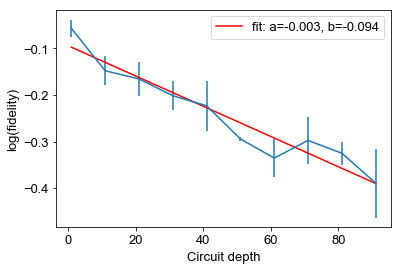

Qubit: 1
[[1.00000000e+00 9.52500000e-01 1.78535711e-02]
 [1.10000000e+01 9.35000000e-01 2.87228132e-02]
 [2.10000000e+01 8.45000000e-01 3.50000000e-02]
 [3.10000000e+01 8.32500000e-01 3.56195171e-02]
 [4.10000000e+01 7.82500000e-01 4.96865173e-02]
 [5.10000000e+01 7.80000000e-01 6.20483682e-02]
 [6.10000000e+01 7.82500000e-01 4.20565096e-02]
 [7.10000000e+01 6.85000000e-01 7.22841615e-02]
 [8.10000000e+01 6.72500000e-01 1.78535711e-02]
 [9.10000000e+01 6.70000000e-01 4.41588043e-02]]
gradient =  -0.004067714743255291
intercept =  -0.05110170968177208


In [22]:
from scipy.optimize import curve_fit
plt.rcParams["font.family"] = "Arial"
matplotlib.rcParams.update({'font.size': 13})
#mpl.rcParams['figure.figsize'] = (20,70)
def plot_results(results):
    
    def gate_independence_fit(x,a,b):
        return a*x+b

    
    for qubit, data in results.items():
        print("Qubit:",qubit)
        plot_list = np.zeros((len(data),3))
        index = 0
        for circuit_length, fidelities in data.items():
            #model,real = fidelities[0],fidelities[1]
            plot_list[index,0] = circuit_length
            plot_list[index,1] = fidelities[0]
            plot_list[index,2] = fidelities[1]
            index += 1
        print(plot_list)
        xdata= plot_list[:,0]
        ydata = np.log(plot_list[:,1])
        error_bar = plot_list[:,2]
        popt,pcov = curve_fit(gate_independence_fit,xdata,ydata)
        print("gradient = ", popt[0])
        print("intercept = ", popt[1])
        if qubit ==0:
            plt.ylabel("log(fidelity)")
            plt.xlabel('Circuit depth')
            plt.errorbar(xdata, ydata, yerr=error_bar)
            plt.plot(xdata,gate_independence_fit(xdata,*popt),'r-',label = 'fit: a=%5.3f, b=%5.3f' %tuple(popt))
            plt.legend()
            plt.savefig("fidelity_plot2.eps")
            plt.show()
        #fig, axes =  plt.subplots(nrows = len(results), ncols = 1, sharex = True, sharey =False)
    
        #axes[plot_index].plot(plot_list[:,0], plot_list[:,1])
        #axes[qubit].plot([x[:][0] for x in plot_list], [y[:][1] for y in plot_list], 'r')
        #axes[plot_index].set_xlim(xmin = 0)
        #axes[plot_index].set_title('Qubit {}'.format(qubit))
    #fig.add_subplot(111, frameon = False)
    #plt.ylabel('Fidelity')
    
plot_results(results)